**Author: Logan O'Brien**

# Step 1: Data Acquisition

**Note:** Througout this document, I do my best to cite the sources where I learned how to do various actions in Python. I feel this may be a bit verboise, and I plan on getting clarification from the teaching staff as to whether or not I need to cite these sources in the future.

I begin by importing the packages I need for this project

In [1]:
import pandas as pd
import matplotlib.pyplot as plt #Source https://www.geeksforgeeks.org/line-chart-in-matplotlib-python/
import datetime

Next, I directly used large portions of the professor's example (see reference [1]) for pulling data from the Wikipdia API to define a function for handily calling the API. The next 3 code cells are exact copies of the professor's example except where modifications are noted.

In [2]:
#
# These are standard python modules
import json, time, urllib.parse
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests

Modification: I added my UW email below and changed the start and end dates to be relevant in the cell below

In [3]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<obrienl@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}


In [4]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


## Get List of Article Names

Having defined the API helper-function above, I next imported the list of article titles to use in the subsequent analysis. **Note: I encountered an issue with passing the 583rd movie, "Victor/Victoria" to the API helper-function that I was unable to resolve, so I removed it from the input file and called the new file "thank_the_academy.AUG.2023.csv - debug.xlsx"**

In [5]:
# Source: https://pandas.pydata.org/docs/reference/api/pandas.read_excel.html
df_articles = pd.read_excel('thank_the_academy.AUG.2023.csv - debug.xlsx')
df_articles.describe()
article_names = df_articles['name']

## Pull Monthly Desktop Access

Next, I call the API to acquire the monthly page view counts for users who accessed the pages via desktop. The Professor's example was also quite helpful in aiding my understanding of how the data the API returns is structured. I saved the accquired data in a JSON file called 'academy_monthly_desktop_201507-202309.json'. 

Source:
- https://www.geeksforgeeks.org/append-to-json-file-using-python/#
- Things I learned from example:
    - the structure of the returned data from the API

In [6]:
# Define articles dictionary
articles_data = {}

article_count = 0

# For each article
for title in article_names:
    
    # Get data from API for article
    article_views = request_pageviews_per_article(title)
    
    month_list = []
    
    # Modify the retrieved data ------------- Source: Got idea for this form of iterating from Prof example
    for month in article_views['items']:
        # Remove access key from each month's entry
        del month['access'] # learned from https://www.geeksforgeeks.org/python-ways-to-remove-a-key-from-dictionary/
        
        # Reconstruct list of months
        month_list.append(month)
        
        # Store in a dictionary of articles
        articles_data[title] = month_list
        
    article_count += 1
    print("------ Added {}: {} ----------".format(article_count,title))
        
# Save to JSON file - Reference: https://www.geeksforgeeks.org/writing-to-file-in-python/
my_file1 = open(r"academy_monthly_desktop_201507-202309.json", "w")
my_file1.write(json.dumps(articles_data, indent=4)) # Source: borrowed part of a line of code from Prof example
my_file1.close()
print("Done!")

------ Added 1: Everything Everywhere All at Once ----------
------ Added 2: All Quiet on the Western Front (2022 film) ----------
------ Added 3: The Whale (2022 film) ----------
------ Added 4: Top Gun: Maverick ----------
------ Added 5: Black Panther: Wakanda Forever ----------
------ Added 6: Avatar: The Way of Water ----------
------ Added 7: Women Talking (film) ----------
------ Added 8: Guillermo del Toro's Pinocchio ----------
------ Added 9: Navalny (film) ----------
------ Added 10: The Elephant Whisperers ----------
------ Added 11: An Irish Goodbye ----------
------ Added 12: The Boy, the Mole, the Fox and the Horse (film) ----------
------ Added 13: RRR (film) ----------
------ Added 14: CODA (2021 film) ----------
------ Added 15: Dune (2021 film) ----------
------ Added 16: The Eyes of Tammy Faye (2021 film) ----------
------ Added 17: No Time to Die ----------
------ Added 18: The Windshield Wiper ----------
------ Added 19: The Long Goodbye (Riz Ahmed album) --------

------ Added 170: Midnight in Paris ----------
------ Added 171: The Help (film) ----------
------ Added 172: A Separation ----------
------ Added 173: The Fantastic Flying Books of Mr. Morris Lessmore ----------
------ Added 174: The Shore (2011 film) ----------
------ Added 175: Undefeated (2011 film) ----------
------ Added 176: The Muppets (film) ----------
------ Added 177: Saving Face (2012 film) ----------
------ Added 178: Beginners ----------
------ Added 179: Rango (2011 film) ----------
------ Added 180: The King's Speech ----------
------ Added 181: Inception ----------
------ Added 182: The Social Network ----------
------ Added 183: The Fighter ----------
------ Added 184: Toy Story 3 ----------
------ Added 185: Alice in Wonderland (2010 film) ----------
------ Added 186: Black Swan (film) ----------
------ Added 187: In a Better World ----------
------ Added 188: The Lost Thing ----------
------ Added 189: God of Love (film) ----------
------ Added 190: The Wolfman (201

------ Added 333: How the Grinch Stole Christmas (2000 film) ----------
------ Added 334: U-571 (film) ----------
------ Added 335: Pollock (film) ----------
------ Added 336: Father and Daughter (film) ----------
------ Added 337: Into the Arms of Strangers: Stories of the Kindertransport ----------
------ Added 338: Quiero ser (I want to be...) ----------
------ Added 339: Big Mama (film) ----------
------ Added 340: American Beauty (1999 film) ----------
------ Added 341: The Matrix ----------
------ Added 342: The Cider House Rules (film) ----------
------ Added 343: Topsy-Turvy ----------
------ Added 344: Sleepy Hollow (film) ----------
------ Added 345: Boys Don't Cry (1999 film) ----------
------ Added 346: Tarzan (1999 film) ----------
------ Added 347: One Day in September ----------
------ Added 348: The Red Violin ----------
------ Added 349: The Old Man and the Sea (1999 film) ----------
------ Added 350: My Mother Dreams the Satan's Disciples in New York ----------
------

------ Added 492: Batman (1989 film) ----------
------ Added 493: Balance (1989 film) ----------
------ Added 494: Rain Man ----------
------ Added 495: Dangerous Liaisons ----------
------ Added 496: Who Framed Roger Rabbit ----------
------ Added 497: Mississippi Burning ----------
------ Added 498: Working Girl ----------
------ Added 499: The Accidental Tourist (film) ----------
------ Added 500: A Fish Called Wanda ----------
------ Added 501: Pelle the Conqueror ----------
------ Added 502: The Accused (1988 film) ----------
------ Added 503: The Appointments of Dennis Jennings ----------
------ Added 504: Beetlejuice ----------
------ Added 505: Bird (1988 film) ----------
------ Added 506: Hôtel Terminus: The Life and Times of Klaus Barbie ----------
------ Added 507: The Milagro Beanfield War ----------
------ Added 508: Tin Toy ----------
------ Added 509: You Don't Have to Die ----------
------ Added 510: The Last Emperor ----------
------ Added 511: Moonstruck ----------
--

------ Added 655: Rocky ----------
------ Added 656: Network (1976 film) ----------
------ Added 657: All the President's Men (film) ----------
------ Added 658: Bound for Glory (1976 film) ----------
------ Added 659: A Star Is Born (1976 film) ----------
------ Added 660: Fellini's Casanova ----------
------ Added 661: The Omen ----------
------ Added 662: Black and White in Color ----------
------ Added 663: Harlan County, USA ----------
------ Added 664: In the Region of Ice ----------
------ Added 665: Leisure (film) ----------
------ Added 666: Number Our Days ----------
------ Added 667: King Kong (1976 film) ----------
------ Added 668: Logan's Run (film) ----------
------ Added 669: One Flew Over the Cuckoo's Nest (film) ----------
------ Added 670: Barry Lyndon ----------
------ Added 671: Jaws (film) ----------
------ Added 672: Dog Day Afternoon ----------
------ Added 673: Nashville (film) ----------
------ Added 674: Shampoo (film) ----------
------ Added 675: The Sunshin

------ Added 814: The Sandpiper ----------
------ Added 815: The Eleanor Roosevelt Story ----------
------ Added 816: To Be Alive! ----------
------ Added 817: 7 Faces of Dr. Lao ----------
------ Added 818: 7th Heaven (1927 film) ----------
------ Added 819: 20,000 Leagues Under the Sea (1954 film) ----------
------ Added 820: Adventures of Don Juan ----------
------ Added 821: The Adventures of Robin Hood ----------
------ Added 822: The African Queen (film) ----------
------ Added 823: Air Force (film) ----------
------ Added 824: The Alamo (1960 film) ----------
------ Added 825: The Alaskan Eskimo ----------
------ Added 826: Albert Schweitzer (film) ----------
------ Added 827: Alexander's Ragtime Band (film) ----------
------ Added 828: All About Eve ----------
------ Added 829: All Quiet on the Western Front (1930 film) ----------
------ Added 830: The Devil and Daniel Webster (film) ----------
------ Added 831: All the King's Men (1949 film) ----------
------ Added 832: Ama Gi

------ Added 973: Forbidden Games ----------
------ Added 974: A Free Soul ----------
------ Added 975: Frenchman's Creek (film) ----------
------ Added 976: From Here to Eternity ----------
------ Added 977: The Garden of Allah (1936 film) ----------
------ Added 978: Gaslight (1944 film) ----------
------ Added 979: Gate of Hell (film) ----------
------ Added 980: The Gay Divorcee ----------
------ Added 981: Gentleman's Agreement ----------
------ Added 982: Gerald McBoing-Boing ----------
------ Added 983: Giant (1956 film) ----------
------ Added 984: Gigi (1958 film) ----------
------ Added 985: Giuseppina ----------
------ Added 986: Give Me Liberty (1936 film) ----------
------ Added 987: Glass (1958 film) ----------
------ Added 988: The Glenn Miller Story ----------
------ Added 989: Going My Way ----------
------ Added 990: Gold Diggers of 1935 ----------
------ Added 991: The Golden Fish (film) ----------
------ Added 992: Goldfinger (film) ----------
------ Added 993: Gone

------ Added 1134: The Naked City ----------
------ Added 1135: National Velvet (film) ----------
------ Added 1136: Nature's Half Acre ----------
------ Added 1137: Naughty Marietta (film) ----------
------ Added 1138: Neighbours (1952 film) ----------
------ Added 1139: Neptune's Daughter (1949 film) ----------
------ Added 1140: Never on Sunday ----------
------ Added 1141: The Night of the Iguana (film) ----------
------ Added 1142: Nights of Cabiria ----------
------ Added 1143: Nine from Little Rock ----------
------ Added 1144: None but the Lonely Heart (film) ----------
------ Added 1145: North West Mounted Police (film) ----------
------ Added 1146: Now, Voyager ----------
------ Added 1147: An Occurrence at Owl Creek Bridge (film) ----------
------ Added 1148: Of Pups and Puzzles ----------
------ Added 1149: Oklahoma! (1955 film) ----------
------ Added 1150: The Old Man and the Sea (1958 film) ----------
------ Added 1151: The Old Mill ----------
------ Added 1152: On the T

------ Added 1290: The Titan: Story of Michelangelo ----------
------ Added 1291: Titanic (1953 film) ----------
------ Added 1292: To Catch a Thief ----------
------ Added 1293: To Each His Own (1946 film) ----------
------ Added 1294: To Kill a Mockingbird (film) ----------
------ Added 1295: Tom Jones (1963 film) ----------
------ Added 1296: Tom Thumb (film) ----------
------ Added 1297: Toot, Whistle, Plunk and Boom ----------
------ Added 1298: Topkapi (film) ----------
------ Added 1299: The Tortoise and the Hare (film) ----------
------ Added 1300: Torture Money ----------
------ Added 1301: Toward Independence ----------
------ Added 1302: Transatlantic (1931 film) ----------
------ Added 1303: The Treasure of the Sierra Madre (film) ----------
------ Added 1304: A Tree Grows in Brooklyn (1945 film) ----------
------ Added 1305: The True Glory ----------
------ Added 1306: The True Story of the Civil War ----------
------ Added 1307: Tweetie Pie ----------
------ Added 1308: T

## Pull Monthly Mobile Access

Next, I pulled the monthly mobile access data from the API and stored it in a JSON file.

To do this, I first created two new dictionaries of parameters to pass to the API helper-function so that I could change the access type to mobile data. Note, there are two categories of mobile data and for this project I pulled both and then combined the page view counts to get the total monthly mobile page view count.

In [7]:
page_params_mobile_app = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}

page_params_mobile_web = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-web",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",   # start and end dates need to be set
    "end":         "2023093000"    # this is likely the wrong end date
}

**Pull each type of mobile data and then combine into a new file**

Now, I pull the mobile data and combine the two categories by adding the views for each article for each month. Then, I save the data to a file called "academy_monthly_mobile_201507-202309.json".

In [8]:
# Define articles dictionary
articles_mobile_app_data = {}

article_count = 0

# For each article
for title in article_names:
    
    # Get data from API for article
    mobile_app_article_views = request_pageviews_per_article(title, request_template=page_params_mobile_app)
    
    month_list = []
    
    # Modify the retrieved data -------------Source: Got idea for this form of iterating from Prof example
    for month in mobile_app_article_views['items']:
        # Remove access key from each month's entry
        del month['access'] # learned from https://www.geeksforgeeks.org/python-ways-to-remove-a-key-from-dictionary/
        
        # Reconstruct list of months
        month_list.append(month)
        
        # Store in a dictionary of articles
        articles_mobile_app_data[title] = month_list
        
    article_count += 1
    print("------ Added {}: {} ----------".format(article_count,title))

print("Finished mobile-app")

# Define articles dictionary
articles_mobile_data = {}

article_count = 0

# For each article
for title in article_names:
    
    # Get data from API for article
    mobile_web_article_views = request_pageviews_per_article(title, request_template=page_params_mobile_web)
    
    month_list = []
    
    # Modify the retrieved data -------------Source: Got idea for this form of iterating from Prof example
    month_index = 0
    for month in mobile_web_article_views['items']:
        # Remove access key from each month's entry
        del month['access'] # learned from https://www.geeksforgeeks.org/python-ways-to-remove-a-key-from-dictionary/
        
        # Add mobile web and mobile app counts
        mobile_app_month_views = articles_mobile_app_data[title][month_index]['views']
        month['views'] = month['views'] + mobile_app_month_views
        
        # Reconstruct list of months
        month_list.append(month)
        
        # Store in a dictionary of articles
        articles_mobile_data[title] = month_list
        
    article_count += 1
    print("------ Added {}: {} ----------".format(article_count,title))
    
# Save to JSON file - Reference: https://www.geeksforgeeks.org/writing-to-file-in-python/
my_file2 = open(r"academy_monthly_mobile_201507-202309.json", "w")
my_file2.write(json.dumps(articles_mobile_data, indent=4)) # Source: borrowed part of a line of code from Prof example
my_file2.close()
print("Finished mobile data")


------ Added 1: Everything Everywhere All at Once ----------
------ Added 2: All Quiet on the Western Front (2022 film) ----------
------ Added 3: The Whale (2022 film) ----------
------ Added 4: Top Gun: Maverick ----------
------ Added 5: Black Panther: Wakanda Forever ----------
------ Added 6: Avatar: The Way of Water ----------
------ Added 7: Women Talking (film) ----------
------ Added 8: Guillermo del Toro's Pinocchio ----------
------ Added 9: Navalny (film) ----------
------ Added 10: The Elephant Whisperers ----------
------ Added 11: An Irish Goodbye ----------
------ Added 12: The Boy, the Mole, the Fox and the Horse (film) ----------
------ Added 13: RRR (film) ----------
------ Added 14: CODA (2021 film) ----------
------ Added 15: Dune (2021 film) ----------
------ Added 16: The Eyes of Tammy Faye (2021 film) ----------
------ Added 17: No Time to Die ----------
------ Added 18: The Windshield Wiper ----------
------ Added 19: The Long Goodbye (Riz Ahmed album) --------

------ Added 170: Midnight in Paris ----------
------ Added 171: The Help (film) ----------
------ Added 172: A Separation ----------
------ Added 173: The Fantastic Flying Books of Mr. Morris Lessmore ----------
------ Added 174: The Shore (2011 film) ----------
------ Added 175: Undefeated (2011 film) ----------
------ Added 176: The Muppets (film) ----------
------ Added 177: Saving Face (2012 film) ----------
------ Added 178: Beginners ----------
------ Added 179: Rango (2011 film) ----------
------ Added 180: The King's Speech ----------
------ Added 181: Inception ----------
------ Added 182: The Social Network ----------
------ Added 183: The Fighter ----------
------ Added 184: Toy Story 3 ----------
------ Added 185: Alice in Wonderland (2010 film) ----------
------ Added 186: Black Swan (film) ----------
------ Added 187: In a Better World ----------
------ Added 188: The Lost Thing ----------
------ Added 189: God of Love (film) ----------
------ Added 190: The Wolfman (201

------ Added 332: Wonder Boys (film) ----------
------ Added 333: How the Grinch Stole Christmas (2000 film) ----------
------ Added 334: U-571 (film) ----------
------ Added 335: Pollock (film) ----------
------ Added 336: Father and Daughter (film) ----------
------ Added 337: Into the Arms of Strangers: Stories of the Kindertransport ----------
------ Added 338: Quiero ser (I want to be...) ----------
------ Added 339: Big Mama (film) ----------
------ Added 340: American Beauty (1999 film) ----------
------ Added 341: The Matrix ----------
------ Added 342: The Cider House Rules (film) ----------
------ Added 343: Topsy-Turvy ----------
------ Added 344: Sleepy Hollow (film) ----------
------ Added 345: Boys Don't Cry (1999 film) ----------
------ Added 346: Tarzan (1999 film) ----------
------ Added 347: One Day in September ----------
------ Added 348: The Red Violin ----------
------ Added 349: The Old Man and the Sea (1999 film) ----------
------ Added 350: My Mother Dreams the

------ Added 491: Work Experience (film) ----------
------ Added 492: Batman (1989 film) ----------
------ Added 493: Balance (1989 film) ----------
------ Added 494: Rain Man ----------
------ Added 495: Dangerous Liaisons ----------
------ Added 496: Who Framed Roger Rabbit ----------
------ Added 497: Mississippi Burning ----------
------ Added 498: Working Girl ----------
------ Added 499: The Accidental Tourist (film) ----------
------ Added 500: A Fish Called Wanda ----------
------ Added 501: Pelle the Conqueror ----------
------ Added 502: The Accused (1988 film) ----------
------ Added 503: The Appointments of Dennis Jennings ----------
------ Added 504: Beetlejuice ----------
------ Added 505: Bird (1988 film) ----------
------ Added 506: Hôtel Terminus: The Life and Times of Klaus Barbie ----------
------ Added 507: The Milagro Beanfield War ----------
------ Added 508: Tin Toy ----------
------ Added 509: You Don't Have to Die ----------
------ Added 510: The Last Emperor -

------ Added 655: Rocky ----------
------ Added 656: Network (1976 film) ----------
------ Added 657: All the President's Men (film) ----------
------ Added 658: Bound for Glory (1976 film) ----------
------ Added 659: A Star Is Born (1976 film) ----------
------ Added 660: Fellini's Casanova ----------
------ Added 661: The Omen ----------
------ Added 662: Black and White in Color ----------
------ Added 663: Harlan County, USA ----------
------ Added 664: In the Region of Ice ----------
------ Added 665: Leisure (film) ----------
------ Added 666: Number Our Days ----------
------ Added 667: King Kong (1976 film) ----------
------ Added 668: Logan's Run (film) ----------
------ Added 669: One Flew Over the Cuckoo's Nest (film) ----------
------ Added 670: Barry Lyndon ----------
------ Added 671: Jaws (film) ----------
------ Added 672: Dog Day Afternoon ----------
------ Added 673: Nashville (film) ----------
------ Added 674: Shampoo (film) ----------
------ Added 675: The Sunshin

------ Added 814: The Sandpiper ----------
------ Added 815: The Eleanor Roosevelt Story ----------
------ Added 816: To Be Alive! ----------
------ Added 817: 7 Faces of Dr. Lao ----------
------ Added 818: 7th Heaven (1927 film) ----------
------ Added 819: 20,000 Leagues Under the Sea (1954 film) ----------
------ Added 820: Adventures of Don Juan ----------
------ Added 821: The Adventures of Robin Hood ----------
------ Added 822: The African Queen (film) ----------
------ Added 823: Air Force (film) ----------
------ Added 824: The Alamo (1960 film) ----------
------ Added 825: The Alaskan Eskimo ----------
------ Added 826: Albert Schweitzer (film) ----------
------ Added 827: Alexander's Ragtime Band (film) ----------
------ Added 828: All About Eve ----------
------ Added 829: All Quiet on the Western Front (1930 film) ----------
------ Added 830: The Devil and Daniel Webster (film) ----------
------ Added 831: All the King's Men (1949 film) ----------
------ Added 832: Ama Gi

------ Added 974: A Free Soul ----------
------ Added 975: Frenchman's Creek (film) ----------
------ Added 976: From Here to Eternity ----------
------ Added 977: The Garden of Allah (1936 film) ----------
------ Added 978: Gaslight (1944 film) ----------
------ Added 979: Gate of Hell (film) ----------
------ Added 980: The Gay Divorcee ----------
------ Added 981: Gentleman's Agreement ----------
------ Added 982: Gerald McBoing-Boing ----------
------ Added 983: Giant (1956 film) ----------
------ Added 984: Gigi (1958 film) ----------
------ Added 985: Giuseppina ----------
------ Added 986: Give Me Liberty (1936 film) ----------
------ Added 987: Glass (1958 film) ----------
------ Added 988: The Glenn Miller Story ----------
------ Added 989: Going My Way ----------
------ Added 990: Gold Diggers of 1935 ----------
------ Added 991: The Golden Fish (film) ----------
------ Added 992: Goldfinger (film) ----------
------ Added 993: Gone with the Wind (film) ----------
------ Added

------ Added 1136: Nature's Half Acre ----------
------ Added 1137: Naughty Marietta (film) ----------
------ Added 1138: Neighbours (1952 film) ----------
------ Added 1139: Neptune's Daughter (1949 film) ----------
------ Added 1140: Never on Sunday ----------
------ Added 1141: The Night of the Iguana (film) ----------
------ Added 1142: Nights of Cabiria ----------
------ Added 1143: Nine from Little Rock ----------
------ Added 1144: None but the Lonely Heart (film) ----------
------ Added 1145: North West Mounted Police (film) ----------
------ Added 1146: Now, Voyager ----------
------ Added 1147: An Occurrence at Owl Creek Bridge (film) ----------
------ Added 1148: Of Pups and Puzzles ----------
------ Added 1149: Oklahoma! (1955 film) ----------
------ Added 1150: The Old Man and the Sea (1958 film) ----------
------ Added 1151: The Old Mill ----------
------ Added 1152: On the Town (film) ----------
------ Added 1153: On the Waterfront ----------
------ Added 1154: One Hundr

------ Added 1292: To Catch a Thief ----------
------ Added 1293: To Each His Own (1946 film) ----------
------ Added 1294: To Kill a Mockingbird (film) ----------
------ Added 1295: Tom Jones (1963 film) ----------
------ Added 1296: Tom Thumb (film) ----------
------ Added 1297: Toot, Whistle, Plunk and Boom ----------
------ Added 1298: Topkapi (film) ----------
------ Added 1299: The Tortoise and the Hare (film) ----------
------ Added 1300: Torture Money ----------
------ Added 1301: Toward Independence ----------
------ Added 1302: Transatlantic (1931 film) ----------
------ Added 1303: The Treasure of the Sierra Madre (film) ----------
------ Added 1304: A Tree Grows in Brooklyn (1945 film) ----------
------ Added 1305: The True Glory ----------
------ Added 1306: The True Story of the Civil War ----------
------ Added 1307: Tweetie Pie ----------
------ Added 1308: Twelve O'Clock High ----------
------ Added 1309: Two Arabian Knights ----------
------ Added 1310: The Two Mousek

------ Added 96: Fences (film) ----------
------ Added 97: Fantastic Beasts and Where to Find Them (film) ----------
------ Added 98: The Jungle Book (2016 film) ----------
------ Added 99: O.J.: Made in America ----------
------ Added 100: Piper (film) ----------
------ Added 101: The Salesman (2016 film) ----------
------ Added 102: Sing (2016 Hungarian film) ----------
------ Added 103: Suicide Squad (2016 film) ----------
------ Added 104: The White Helmets (film) ----------
------ Added 105: Zootopia ----------
------ Added 106: Spotlight (film) ----------
------ Added 107: Mad Max: Fury Road ----------
------ Added 108: The Revenant (2015 film) ----------
------ Added 109: Bridge of Spies (film) ----------
------ Added 110: The Big Short (film) ----------
------ Added 111: The Danish Girl (film) ----------
------ Added 112: Room (2015 film) ----------
------ Added 113: The Hateful Eight ----------
------ Added 114: Ex Machina (film) ----------
------ Added 115: Inside Out (2015 f

------ Added 262: Syriana ----------
------ Added 263: March of the Penguins ----------
------ Added 264: Six Shooter (film) ----------
------ Added 265: The Moon and the Son: An Imagined Conversation ----------
------ Added 266: A Note of Triumph: The Golden Age of Norman Corwin ----------
------ Added 267: Tsotsi ----------
------ Added 268: Wallace & Gromit: The Curse of the Were-Rabbit ----------
------ Added 269: Million Dollar Baby ----------
------ Added 270: The Aviator (2004 film) ----------
------ Added 271: Ray (film) ----------
------ Added 272: The Incredibles ----------
------ Added 273: Finding Neverland (film) ----------
------ Added 274: Sideways ----------
------ Added 275: Lemony Snicket's A Series of Unfortunate Events ----------
------ Added 276: Spider-Man 2 ----------
------ Added 277: Eternal Sunshine of the Spotless Mind ----------
------ Added 278: The Motorcycle Diaries (film) ----------
------ Added 279: The Sea Inside ----------
------ Added 280: Born into 

------ Added 423: Bob's Birthday ----------
------ Added 424: Blue Sky (1994 film) ----------
------ Added 425: Schindler's List ----------
------ Added 426: The Piano ----------
------ Added 427: Jurassic Park (film) ----------
------ Added 428: Philadelphia (film) ----------
------ Added 429: The Fugitive (1993 film) ----------
------ Added 430: The Age of Innocence (1993 film) ----------
------ Added 431: The Wrong Trousers ----------
------ Added 432: Belle Epoque (film) ----------
------ Added 433: I Am a Promise: The Children of Stanton Elementary School ----------
------ Added 434: Mrs. Doubtfire ----------
------ Added 435: Schwarzfahrer ----------
------ Added 436: Defending Our Lives ----------
------ Added 437: Unforgiven ----------
------ Added 438: Howards End (film) ----------
------ Added 439: Bram Stoker's Dracula (1992 film) ----------
------ Added 440: Aladdin (1992 Disney film) ----------
------ Added 441: The Crying Game ----------
------ Added 442: Scent of a Woman

------ Added 585: If You Love This Planet ----------
------ Added 586: Just Another Missing Kid ----------
------ Added 587: A Shocking Accident ----------
------ Added 588: Tango (1981 film) ----------
------ Added 589: Begin the Beguine (film) ----------
------ Added 590: Quest for Fire (film) ----------
------ Added 591: Chariots of Fire ----------
------ Added 592: Raiders of the Lost Ark ----------
------ Added 593: Reds (film) ----------
------ Added 594: On Golden Pond (1981 film) ----------
------ Added 595: Arthur (1981 film) ----------
------ Added 596: An American Werewolf in London ----------
------ Added 597: Close Harmony (1981 film) ----------
------ Added 598: Crac ----------
------ Added 599: Genocide (1981 film) ----------
------ Added 600: Mephisto (1981 film) ----------
------ Added 601: Violet (1981 film) ----------
------ Added 602: Ordinary People ----------
------ Added 603: Tess (1979 film) ----------
------ Added 604: Raging Bull ----------
------ Added 605: F

------ Added 747: The Resurrection of Broncho Billy ----------
------ Added 748: Midnight Cowboy ----------
------ Added 749: Butch Cassidy and the Sundance Kid ----------
------ Added 750: Hello, Dolly! (film) ----------
------ Added 751: Z (1969 film) ----------
------ Added 752: Anne of the Thousand Days ----------
------ Added 753: They Shoot Horses, Don't They? (film) ----------
------ Added 754: Marooned (1969 film) ----------
------ Added 755: The Magic Machines ----------
------ Added 756: The Prime of Miss Jean Brodie (film) ----------
------ Added 757: True Grit (1969 film) ----------
------ Added 758: Arthur Rubinstein – The Love of Life ----------
------ Added 759: Cactus Flower (film) ----------
------ Added 760: Czechoslovakia 1968 ----------
------ Added 761: It's Tough to Be a Bird ----------
------ Added 762: Oliver! (film) ----------
------ Added 763: The Lion in Winter (1968 film) ----------
------ Added 764: Romeo and Juliet (1968 film) ----------
------ Added 765: 

------ Added 905: Churchill's Island ----------
------ Added 906: Cimarron (1931 film) ----------
------ Added 907: The Circus (1928 film) ----------
------ Added 908: Citizen Kane ----------
------ Added 909: City of Wax ----------
------ Added 910: Cleopatra (1934 film) ----------
------ Added 911: Cleopatra (1963 film) ----------
------ Added 912: Climbing the Matterhorn ----------
------ Added 913: Come and Get It (1936 film) ----------
------ Added 914: Come Back, Little Sheba (1952 film) ----------
------ Added 915: Coquette (film) ----------
------ Added 916: The Country Cousin ----------
------ Added 917: The Country Girl (1954 film) ----------
------ Added 918: Cover Girl (film) ----------
------ Added 919: The Cowboy and the Lady (1938 film) ----------
------ Added 920: Crash Dive ----------
------ Added 921: Crashing the Water Barrier ----------
------ Added 922: The Critic (1963 film) ----------
------ Added 923: La Cucaracha (1934 film) ----------
------ Added 924: Cyrano 

------ Added 1067: Knighty Knight Bugs ----------
------ Added 1068: Kokoda Front Line! ----------
------ Added 1069: Kon-Tiki (1950 film) ----------
------ Added 1070: Krakatoa (film) ----------
------ Added 1071: Kukan ----------
------ Added 1072: La Strada ----------
------ Added 1073: La Dolce Vita ----------
------ Added 1074: Lady Be Good (1941 film) ----------
------ Added 1075: The Last Command (1928 film) ----------
------ Added 1076: Laura (1944 film) ----------
------ Added 1077: The Lavender Hill Mob ----------
------ Added 1078: Lawrence of Arabia (film) ----------
------ Added 1079: Leave Her to Heaven ----------
------ Added 1080: Lend a Paw ----------
------ Added 1081: Les Girls ----------
------ Added 1082: A Letter to Three Wives ----------
------ Added 1083: The Life of Emile Zola ----------
------ Added 1084: Light in the Window ----------
------ Added 1085: Lili ----------
------ Added 1086: Lilies of the Field (1963 film) ----------
------ Added 1087: The Kidnap

------ Added 1226: The Snake Pit ----------
------ Added 1227: Snow White and the Seven Dwarfs (1937 film) ----------
------ Added 1228: So Much for So Little ----------
------ Added 1229: So This Is Harris! ----------
------ Added 1230: The Solid Gold Cadillac ----------
------ Added 1231: Some Like It Hot ----------
------ Added 1232: Somebody Up There Likes Me (1956 film) ----------
------ Added 1233: The Song of Bernadette (film) ----------
------ Added 1234: Song of the South ----------
------ Added 1235: Song Without End ----------
------ Added 1236: Sons and Lovers (film) ----------
------ Added 1237: Sons of Liberty (film) ----------
------ Added 1238: South Pacific (1958 film) ----------
------ Added 1239: Spartacus (film) ----------
------ Added 1240: Spawn of the North ----------
------ Added 1241: Speaking of Animals and Their Families ----------
------ Added 1242: Speedy Gonzales (film) ----------
------ Added 1243: Spellbound (1945 film) ----------
------ Added 1244: Sple

## Construct Cumulative Dataset

The last dataset I accquire is the cumulative data. This is accomplished by adding the mobile and desktop monthly page views to find the total monthly page view for each article for each month. I begin this step by loading the JSON files I created in the previous steps

In [9]:
# Load the JSON files: https://www.geeksforgeeks.org/append-to-json-file-using-python/#
my_file3 = open(r"academy_monthly_desktop_201507-202309.json", "r")
desktop_data = json.loads(my_file3.read())
my_file3.close()

my_file4 = open(r"academy_monthly_mobile_201507-202309.json", "r")
mobile_data = json.loads(my_file4.read())
my_file4.close()

cumulative_data = dict(desktop_data) # Source: https://www.w3schools.com/python/python_dictionaries_copy.asp

article_count = 0

# For each article
for title in article_names:
    month_list = []
    
    # Modify the retrieved data -------------Source: Got idea for this form of iterating from Prof example
    # Loop through all months of that article
    month_index = 0
    for month in cumulative_data[title]: 
        
        # Add desktop and mobile view counts
        mobile_month_views = mobile_data[title][month_index]['views']
        desktop_month_views = desktop_data[title][month_index]['views']
        month['views'] = mobile_month_views + desktop_month_views
        
#         # Reconstruct list of months
#         month_list.append(month)
        
#         # Store in a dictionary of articles
#         cumulative_data[title] = month_list
        
    article_count += 1
    print("------ Added {}: {} ----------".format(article_count,title))

    
# Save to JSON file - Reference: https://www.geeksforgeeks.org/writing-to-file-in-python/
my_file5 = open(r"academy_monthly_cumulative_201507-202309.json", "w")
my_file5.write(json.dumps(cumulative_data, indent=4)) # Source: borrowed part of a line of code from Prof example
my_file5.close()
print("Finished cumulative data")

------ Added 1: Everything Everywhere All at Once ----------
------ Added 2: All Quiet on the Western Front (2022 film) ----------
------ Added 3: The Whale (2022 film) ----------
------ Added 4: Top Gun: Maverick ----------
------ Added 5: Black Panther: Wakanda Forever ----------
------ Added 6: Avatar: The Way of Water ----------
------ Added 7: Women Talking (film) ----------
------ Added 8: Guillermo del Toro's Pinocchio ----------
------ Added 9: Navalny (film) ----------
------ Added 10: The Elephant Whisperers ----------
------ Added 11: An Irish Goodbye ----------
------ Added 12: The Boy, the Mole, the Fox and the Horse (film) ----------
------ Added 13: RRR (film) ----------
------ Added 14: CODA (2021 film) ----------
------ Added 15: Dune (2021 film) ----------
------ Added 16: The Eyes of Tammy Faye (2021 film) ----------
------ Added 17: No Time to Die ----------
------ Added 18: The Windshield Wiper ----------
------ Added 19: The Long Goodbye (Riz Ahmed album) --------

Finished cumulative data


**Note: There is some sort of bug in my code that overwrites my desktop_data dictionary views counts with the cumulative views counts when running the cell above. I was unable to determine the cause of the issue, though I suspect it was an issue with not doing a deep copy of the dictionary. I can get around it, though, by just reloading my JSON files with the correct data.**

In [10]:
# Load the JSON files: https://www.geeksforgeeks.org/append-to-json-file-using-python/#
my_file3 = open(r"academy_monthly_desktop_201507-202309.json", "r")
desktop_data = json.loads(my_file3.read())
my_file3.close()

my_file4 = open(r"academy_monthly_mobile_201507-202309.json", "r")
mobile_data = json.loads(my_file4.read())
my_file4.close()

# Step 2: Data Processing and Analysis

**Maximum Average and Minimum Average**

Begin the analysis by caclulating the average monthly page requests for desktop and mobile access

In [11]:
# Create lists for the data: 
desktop_avgs_list = []
mobile_avgs_list = []

# Calculate the average monthly views for desktop
for title in article_names: # loop through each article
    monthly_views_list = []    
    for month in desktop_data[title]: # loop through each month
        monthly_views_list.append(month['views'])
    
    # Find avg for title: Source: https://www.geeksforgeeks.org/find-average-list-python/#
    desktop_avgs_list.append(sum(monthly_views_list) / len(monthly_views_list))

# Calculate the average monthly views for mobile
for title in article_names: # loop through each article
    monthly_views_list = []    
    for month in mobile_data[title]: # loop through each month #Source???? wouldn't have thought
        # to do for ____ in one level down without seeing it... Have to cite? Where is the line?
        monthly_views_list.append(month['views'])
    
    # Find avg for title: Source: https://www.geeksforgeeks.org/find-average-list-python/#
    mobile_avgs_list.append(sum(monthly_views_list) / len(monthly_views_list))
           

Find the miniumum and maximum averages

In [12]:
# Convert dictionaries to dataFrames
# Source: https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/
df_desktop = pd.DataFrame(list(zip(article_names, desktop_avgs_list)), columns=['Name', 'Avg_views'])
df_mobile = pd.DataFrame(list(zip(article_names, mobile_avgs_list)), columns=['Name', 'Avg_views'])

# Find the min and max values
# Source: https://www.geeksforgeeks.org/how-to-sort-pandas-dataframe/
# https://stackoverflow.com/questions/48719937/getting-typeerror-reduction-operation-argmax-not-allowed-for-this-dtype-when
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html
# https://www.geeksforgeeks.org/python-pandas-dataframe-idxmax/
# https://www.geeksforgeeks.org/find-maximum-values-position-in-columns-and-rows-of-a-dataframe-in-pandas/
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html

df_desktop.sort_values(by=['Avg_views'], inplace=True) 
desktop_min_title = df_desktop.iloc[0,0]
desktop_max_title = df_desktop.iloc[-1,0]

df_mobile.sort_values(by=['Avg_views'], inplace=True)
mobile_min_title = df_mobile.iloc[0,0]
mobile_max_title = df_mobile.iloc[-1,0]

# Make lists of time-series data
desktop_min_dates = []
desktop_max_dates = []
mobile_min_dates = []
mobile_max_dates = []

desktop_min_values = []
desktop_max_values = []
mobile_min_values = []
mobile_max_values = []

for month in desktop_data[desktop_min_title]:
    desktop_min_dates.append(month['timestamp'])
    desktop_min_values.append(month['views'])
    
for month in desktop_data[desktop_max_title]:
    desktop_max_dates.append(month['timestamp'])
    desktop_max_values.append(month['views'])
    
for month in mobile_data[mobile_min_title]:
    mobile_min_dates.append(month['timestamp'])
    mobile_min_values.append(month['views'])
    
for month in mobile_data[mobile_max_title]:
    mobile_max_dates.append(month['timestamp'])
    mobile_max_values.append(month['views'])

Debugging:

Sources:
- https://www.geeksforgeeks.org/line-chart-in-matplotlib-python/
- https://www.geeksforgeeks.org/matplotlib-pyplot-legend-in-python/#

Plot the results of the analysis

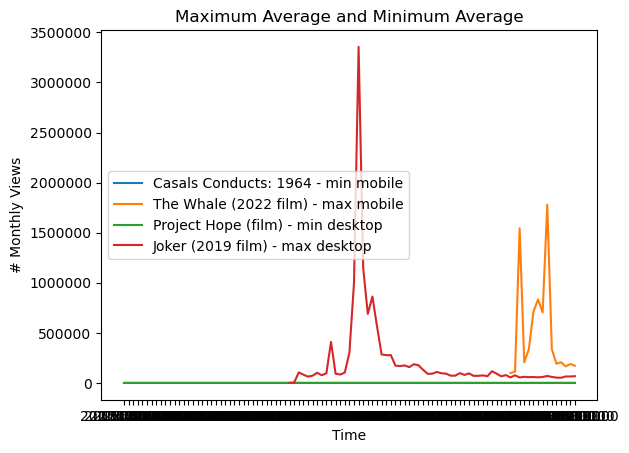

In [13]:
x = mobile_min_dates
y = mobile_min_values
plt.plot(x, y, label = mobile_min_title + " - min mobile")

x1 = mobile_max_dates
y1 = mobile_max_values
plt.plot(x1, y1, label = mobile_max_title+ ' - max mobile')

x2 = desktop_min_dates
y2 = desktop_min_values
plt.plot(x2, y2, label = desktop_min_title + ' - min desktop')

x3 = desktop_max_dates
y3 = desktop_max_values
plt.plot(x3, y3, label = desktop_max_title + ' - max desktop')

# Ensure y-axis is not formatted in scientific notation
# Sources: https://stackoverflow.com/questions/28371674/prevent-scientific-notation
# https://stackoverflow.com/questions/46735745/how-to-control-scientific-notation-in-matplotlib
plt.ticklabel_format(style='plain', axis='y')

# Add legend
plt.legend()

plt.xlabel("Time")
plt.ylabel("# Monthly Views")
plt.title("Maximum Average and Minimum Average")

plt.show()

If I have more time worry about date formatting, else skip:
- https://docs.python.org/3/library/datetime.html
- https://docs.python.org/3/library/datetime.html#datetime.datetime.strptime
- https://stackoverflow.com/questions/19934248/nameerror-name-datetime-is-not-defined
- https://stackoverflow.com/questions/19480028/attributeerror-datetime-module-has-no-attribute-strptime

In [14]:
# desktop_min_dates = [datetime.datetime.strptime(e, "%Y") for e in desktop_min_dates]

**Top 10 Peak Page Views:** Plot a time series chart for top 10 desktop and mobile pages (based on peak viewership)

I begin by finding the peak viewership

In [15]:
# Find peak views for desktop articles
peak_desktop_article_views = []

for title in article_names:
    monthly_views_list = []
    for month in desktop_data[title]: # Loop through each month Source: can I copy my own line
        # without citing?
        monthly_views_list.append(month['views'])
    
    # Find peak month for each article. Source: https://www.geeksforgeeks.org/python-list-max-method/   
    peak_desktop_article_views.append(max(monthly_views_list))  
    
# Find peak views for mobile articles
peak_mobile_article_views = []

for title in article_names:
    monthly_views_list = []
    for month in mobile_data[title]: # Loop through each month Source: can I copy my own line
        # without citing?
        monthly_views_list.append(month['views'])
    
    # Find peak month for each article. Source: https://www.geeksforgeeks.org/python-list-max-method/   
    peak_mobile_article_views.append(max(monthly_views_list)) 
    
# Create data frames to sort and find top 10 desktop and mobile articles
# Source: https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/
df_desktop = pd.DataFrame(list(zip(article_names, peak_desktop_article_views)),
                          columns=['Name', 'Peak_views'])
df_mobile = pd.DataFrame(list(zip(article_names, peak_mobile_article_views)),
                         columns=['Name', 'Peak_views'])

# Find the top 10 articles for desktop and mobile
# Source: https://www.geeksforgeeks.org/how-to-sort-pandas-dataframe/
# https://stackoverflow.com/questions/48719937/getting-typeerror-reduction-operation-argmax-not-allowed-for-this-dtype-when
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html
# https://www.geeksforgeeks.org/python-pandas-dataframe-idxmax/
# https://www.geeksforgeeks.org/find-maximum-values-position-in-columns-and-rows-of-a-dataframe-in-pandas/
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html

df_desktop.sort_values(by=['Peak_views'], ascending=False, inplace=True)
df_desktop_top_titles = df_desktop.iloc[0:10, 0] # Source: https://pandas.pydata.org/docs/user_guide/indexing.html
desktop_top_titles_ls = df_desktop_top_titles.tolist() # Source: https://www.geeksforgeeks.org/python-pandas-series-tolist/

df_mobile.sort_values(by=['Peak_views'], ascending=False, inplace=True)
df_mobile_top_titles = df_mobile.iloc[0:10, 0] # Source: https://pandas.pydata.org/docs/user_guide/indexing.html
mobile_top_titles_ls = df_mobile_top_titles.tolist() # Source: https://www.geeksforgeeks.org/python-pandas-series-tolist/

# Make lists of time-series data
desktop_dates_2d_ls = []
mobile_dates_2d_ls = []

desktop_values_2d_ls = []
mobile_values_2d_ls = []

# Iterate through top desktop articles
for title in desktop_top_titles_ls:
    article_views = []
    article_dates = []
    
    for month in desktop_data[title]:
        article_dates.append(month['timestamp'])
        article_views.append(month['views'])
        
    desktop_dates_2d_ls.append(article_dates)
    desktop_values_2d_ls.append(article_views)
    
# Iterate through top mobile articles
for title in mobile_top_titles_ls:
    article_dates = []
    article_views = []
    
    for month in mobile_data[title]:
        article_dates.append(month['timestamp'])
        article_views.append(month['views'])
    
    mobile_dates_2d_ls.append(article_dates)
    mobile_values_2d_ls.append(article_views)
    

Next, I plot the resulting time series data for the top 10 desktop and top 10 mobile accessed articles

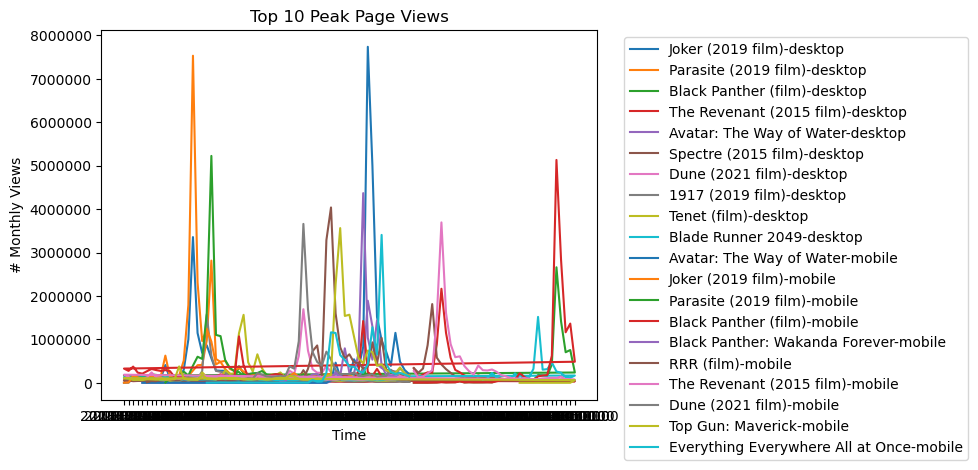

In [16]:
# Plot the desktop time series data
for i in range(10):
    x = desktop_dates_2d_ls[i]
    y = desktop_values_2d_ls[i]
    article_label = desktop_top_titles_ls[i] + "-desktop"
    plt.plot(x, y, label = article_label)

# Plot the mobile time series data
for i in range(10):
    x = mobile_dates_2d_ls[i]
    y = mobile_values_2d_ls[i]
    article_label = mobile_top_titles_ls[i] + "-mobile"
    plt.plot(x, y, label = article_label)

# Ensure y-axis is not formatted in scientific notation
# Sources: https://stackoverflow.com/questions/28371674/prevent-scientific-notation
# https://stackoverflow.com/questions/46735745/how-to-control-scientific-notation-in-matplotlib
plt.ticklabel_format(style='plain', axis='y')   

plt.xlabel("Time")
plt.ylabel("# Monthly Views")
plt.title("Top 10 Peak Page Views")

# Add legend
# Used special formatting for the legen that I learned from here:
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot.
# Specifically ImportanceOfBeingErnest's post.
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

**Fewest Months of Data:** Plot a time series chart for the 10 articles with fewest months of data for desktop access and fewest months of data for mobile access, respectively.

I begin by finding the number of months of data there is for each article and then extract the time series data for the 10 articles with the fewest months of data for desktop and mobile access, from the JSON data files.

In [17]:
# Begin by finding the count of months of data for each article
desktop_article_date_counts = []
mobile_article_date_counts = []

for title in article_names:
    desk_count = len(desktop_data[title])
    desktop_article_date_counts.append(desk_count)
    
    mobile_count = len(mobile_data[title])
    mobile_article_date_counts.append(mobile_count)

# Create data frames to sort and find 10 desktop and mobile articles with fewest months of data
# Source: https://www.geeksforgeeks.org/create-a-pandas-dataframe-from-lists/
df_desktop = pd.DataFrame(list(zip(article_names, desktop_article_date_counts)),
                          columns=['Name', 'Month_Counts'])
df_mobile = pd.DataFrame(list(zip(article_names, mobile_article_date_counts)),
                         columns=['Name', 'Month_Counts'])

# Find the top 10 articles for desktop and mobile
# Source: https://www.geeksforgeeks.org/how-to-sort-pandas-dataframe/
# https://stackoverflow.com/questions/48719937/getting-typeerror-reduction-operation-argmax-not-allowed-for-this-dtype-when
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.idxmax.html
# https://www.geeksforgeeks.org/python-pandas-dataframe-idxmax/
# https://www.geeksforgeeks.org/find-maximum-values-position-in-columns-and-rows-of-a-dataframe-in-pandas/
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop.html
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.sort_values.html

df_desktop.sort_values(by=['Month_Counts'], ascending=True, inplace=True)
df_desktop_top_titles = df_desktop.iloc[0:10, 0] # Source: https://pandas.pydata.org/docs/user_guide/indexing.html
desktop_top_titles_ls = df_desktop_top_titles.tolist() # Source: https://www.geeksforgeeks.org/python-pandas-series-tolist/

df_mobile.sort_values(by=['Month_Counts'], ascending=True, inplace=True)
df_mobile_top_titles = df_mobile.iloc[0:10, 0] # Source: https://pandas.pydata.org/docs/user_guide/indexing.html
mobile_top_titles_ls = df_mobile_top_titles.tolist() # Source: https://www.geeksforgeeks.org/python-pandas-series-tolist/

# Make lists of time-series data
desktop_dates_2d_ls = []
mobile_dates_2d_ls = []

desktop_values_2d_ls = []
mobile_values_2d_ls = []

# Iterate through top desktop articles
for title in desktop_top_titles_ls:
    article_views = []
    article_dates = []
    
    for month in desktop_data[title]:
        article_dates.append(month['timestamp'])
        article_views.append(month['views'])
        
    desktop_dates_2d_ls.append(article_dates)
    desktop_values_2d_ls.append(article_views)
    
# Iterate through top mobile articles
for title in mobile_top_titles_ls:
    article_dates = []
    article_views = []
    
    for month in mobile_data[title]:
        article_dates.append(month['timestamp'])
        article_views.append(month['views'])
    
    mobile_dates_2d_ls.append(article_dates)
    mobile_values_2d_ls.append(article_views)

Then, I plot the resulting time series data

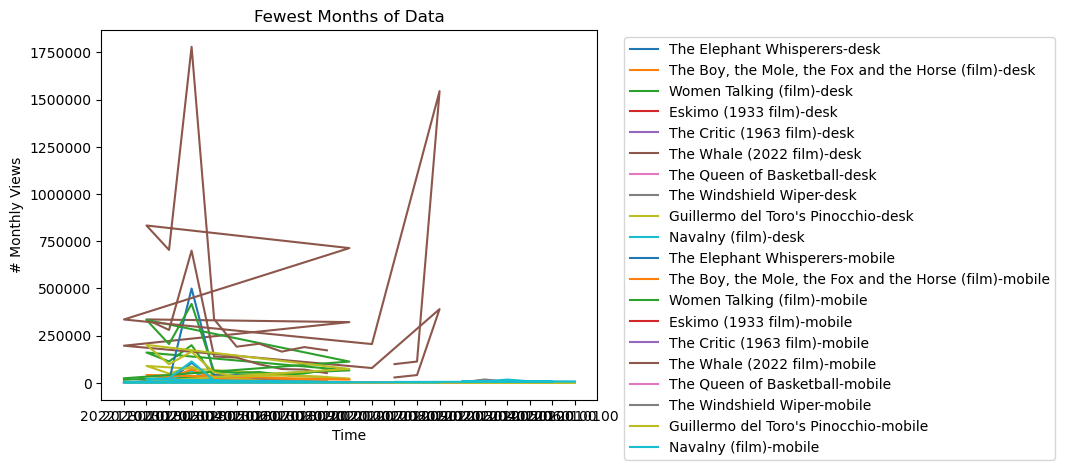

In [18]:
# Plot the desktop time series data
for i in range(10):
    x = desktop_dates_2d_ls[i]
    y = desktop_values_2d_ls[i]
    article_label = desktop_top_titles_ls[i] + "-desk"
    plt.plot(x, y, label = article_label)

# Plot the mobile time series data
for i in range(10):
    x = mobile_dates_2d_ls[i]
    y = mobile_values_2d_ls[i]
    article_label = mobile_top_titles_ls[i] + "-mobile"
    plt.plot(x, y, label = article_label)
    
# Ensure y-axis is not formatted in scientific notation
# Sources: https://stackoverflow.com/questions/28371674/prevent-scientific-notation
# https://stackoverflow.com/questions/46735745/how-to-control-scientific-notation-in-matplotlib
plt.ticklabel_format(style='plain', axis='y')

plt.xlabel("Time")
plt.ylabel("# Monthly Views")
plt.title("Fewest Months of Data")

# Add legend
# Used special formatting for the legen that I learned from here:
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-outside-the-plot.
# Specifically ImportanceOfBeingErnest's post.
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")

plt.show()

# References

- [1]. wp_article_views_example.ipynb. This code is licensed CC-BY (https://creativecommons.org/licenses/by/4.0/#)